In [1]:
import scipy
import numpy as np
from matplotlib import cm,colors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from control import dare
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.utils.optical_input import *
from single_photons.utils.metrics import *
from single_photons.environment import Cavity_Particle
from single_photons.simulation.simulation_cavity import simulation_c
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

C:\Users\jorge\anaconda2023.3\lib\site-packages\single_photons-0.0.1-py3.10.egg\single_photons\simulation\simulation_particle.py:3: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module


In [2]:
delta_t = 1e-9
rho = 2200
index_refraction = 1.4440
T = 293
p = 1e-6
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
eta_detection = 0.178
control_step = int(30e-9/delta_t) 
fs = 1/(control_step*delta_t)
cavity_waist = 100e-6
cavity_length = 50e-3
tweezer_waist = 0.6e-6
detuning_ratio = 0.25 
cavity_linewidth_ratio = 0.5
optomechanical_coupling_ratio = 0.28
g_fb_ratio = 5

In [3]:
gamma, omega, ba_force, std_detection, std_z, g_cs, detuning, cavity_linewidth =\
compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection, 
                                     cavity_length, cavity_waist, detuning_ratio, cavity_linewidth_ratio,
                                    T = T, rho = rho, index_refraction = index_refraction)

zp_x = compute_zpx(omega, radius, rho = rho)
std_detection = std_detection/zp_x

period = 2*np.pi/omega
t = np.arange(0, 500*period, delta_t)
N = t.shape[0]

coupling = (1/(4*np.pi))*(ba_force**2)

In [4]:
cavity_linewidth = cavity_linewidth_ratio * omega
g_cs = optomechanical_coupling_ratio * omega
env = Cavity_Particle(
    omega,
    gamma,
    detuning,        
    cavity_linewidth,
    g_cs,
    coupling,
    radius=radius,
    eta_detection=eta_detection,
    T=T,
    g_fb_ratio = g_fb_ratio
)

In [5]:
variance_process = env.thermal_force_std**2 + env.backaction_std**2
Q = control_step*delta_t/2*np.array(
    [
        [env.__shot_std__**2, 0, 0, 0],
        [0, env.__shot_std__**2, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process]
    ])
#R = np.diag([0, 0, np.power(std_detection,2), 0])
R = np.array([[np.power(std_detection, 2)]])
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cov_ss = dare(np.transpose(Ad), Bd, Q, R)[0]

In [6]:
def post_process_snr(snr):
    if not np.equal(snr, None).sum():
        mean_pos = np.mean(snr)
        std_pos = np.std(snr)
    else:
        mean_pos = 0
        std_pos = 0
    return mean_pos, std_pos

In [7]:
numbers = np.array([1])
width = np.array([1])
vals = []
runs = 5
subsampling = 1000
laser_linewidth = 0
metrics = {''}
for photon_number in numbers:
    for run in tqdm(range(runs)):
        env = Cavity_Particle(
            omega,
            gamma,
            detuning,
            cavity_linewidth,
            optomechanical_coupling_ratio*omega,
            coupling,
            radius=radius,
            eta_detection=eta_detection,
            T=T
        )
        optical_input, centers, pulse_width = create_pulse(photon_number, env.__kappa__, 
                                                           laser_linewidth, t,
                                                           cavity_length, cavity_linewidth,
                                                           env.__detuning__, pulse_width = width)
        val = np.zeros(int(optical_input.shape[1]/subsampling))
        for i in range(len(val)):
            val[i] = np.sqrt(np.sum(np.power(abs(optical_input[:,subsampling*i]),2)))
        vals.append(val)
vals = np.array(vals)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


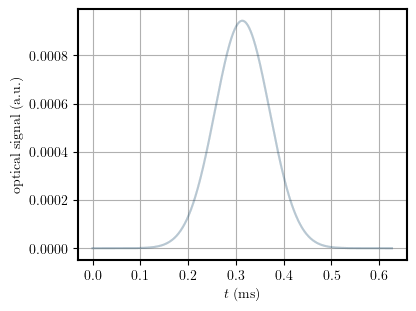

In [9]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure()
factor = 1
fig.set_size_inches(4.25*factor, 3.25*factor, forward=True)

for el in vals:
    plt.plot(1e3*t[::100][:el.shape[0]], el, color = colors[2], alpha = 0.07)
plt.xlabel(r'$t$ (ms)')
plt.ylabel(r'optical signal (a.u.)')
plt.grid()
plt.show()

In [45]:
numbers = np.array([1])
width = np.array([1])
runs = 100
subsampling = 1000
log_linewidths = np.linspace(0,4,11)
linewidths  = np.power(log_linewidths,10)
ratios = []
metrics = {''}
for l in linewidths:
for photon_number in numbers:
    for run in tqdm(range(runs)):
        env = Cavity_Particle(
            omega,
            gamma,
            detuning,
            cavity_linewidth,
            optomechanical_coupling_ratio*omega,
            coupling,
            radius=radius,
            eta_detection=eta_detection,
            T=T
        )
        optical_input, centers, pulse_width = create_pulse(photon_number, env.__kappa__, 
                                                           laser_linewidth, t,
                                                           cavity_length, cavity_linewidth,
                                                           env.__detuning__, pulse_width = width)
        val = np.zeros(int(optical_input.shape[1]/subsampling))
        for i in range(len(val)):
            val[i] = np.sqrt(np.sum(np.power(abs(optical_input[:,subsampling*i]),2)))
        vals.append(val)
vals = np.array(vals)

(6267,)